# Brief tutorial for the PyAPD library

## Installation via pip

This should be as easy as running the command below. Note that `PyAPD` relies on
- `pykeops` -- a kernel operations library which ensures we are able to always use near 100% of GPU power at our disposal.
- `torch` -- the machine learning library that is GPU friendly, we use it for defining the model, storing data and linking between `torch` tensors and `PyKeOps` Lazy Tensors
- `pytorch-minimize` -- for optimisation routines, which are designed to mimic `scipy` while remaining on the GPU.
- `matplotlib` -- for plotting
- `numpy` -- for some of the data manipulation, but almost always we may use `torch` instead and way get rid of `numpy` altogether soon.
- `scipy` -- `pytorch-minimize` calls `scipy` and we manually override one of the `pytorch-minimize` modules to ensure that error tolerance for gradients can be vectorial, that is different for each component of the gradient.

In the near future we will most likely add `pyvista` to the list of dependencies to have internal 3D plotting capabilities.

These dependencies are installed automatically when installing `PyAPD`.

In [ ]:
pip install PyAPD -U

## Example usage with brief description

We begin by importing the package and defining an instance of an `apd_system`, which is the central object of the library.

In [2]:
# first import the whole package
import PyAPD

In [3]:
?PyAPD.apd_system

Init signature:
PyAPD.apd_system(
    domain=None,
    X=None,
    As=None,
    W=None,
    target_masses=None,
    pixel_params=None,
    dt=torch.float32,
    device='cuda',
    N=10,
    D=2,
    ani_thres=0.25,
    heuristic_W=False,
    radius_of_exclusion=0.01,
    det_constraint=True,
    error_tolerance=0.01,
    pixel_size_prefactor=2,
    seed=-1,
)
Docstring:      An anisotropic power diagram system.
Init docstring: TODO: add description of the init.
File:           /global/cfs/cdirs/m4369/mambaforge/lib/python3.10/site-packages/PyAPD/apds.py
Type:           type
Subclasses:     

In [4]:
apd1 = PyAPD.apd_system()

By default, we assemble a $D=2$ dimensional system with $N=10$ grains occupying a square domain $[0,1]^D$.

In [5]:
apd1.N

10

In [6]:
apd1.D

2

In [7]:
apd1.domain

tensor([[0., 1.],
        [0., 1.]], device='cuda:0')

From the GPU perspective, other important parameters are
- `apd1.dt` defining the data type, either `torch.float32` (single precision) or `torch.float64` (double precision). Single precision will be generally much faster as most GPUs are geared towards single precision arithmetic. Unfortunately for our application, when $N$ is large, this can lead to precision loss, we advise caution.
- `apd1.device` which by default gets set to `"cuda" if torch.cuda.is_available() else "cpu"`, meaning that we work with GPUs when they are available, otherwise we rever to a cpu.

While these parameters can be adjusted for an already defined `apd_system`, there may be some bugs in the implementation, so a switch to a new instance of `apd_system` is advised if one wants to switch to a different device or a different data type. 

In [8]:
apd1.dt

torch.float32

In [9]:
apd1.device

'cuda'

We also have several parameters that are important for fitting optimal APDs and generating synthetic microstructure.

- `apd1.error_tolerance` is the relative error tolerance we are happy with with respect to volumes of grains, by default set to $\varepsilon = 0.01$. If we want $i$th grain to have volume $v_i$, this means that we are happy to accept that a grain, $L_i$, has volume satisfying either (option `error_wrt_each_grain = True` in solvers (to be discused below)):
$$
\frac{\big||L_i|- v_i\big|}{v_i} \leq \varepsilon.
$$
or (option `error_wrt_each_grain = False`):
$$
\frac{\big||L_i|- v_i\big|}{\min_j v_j} \leq \varepsilon.
$$

In [10]:
apd1.error_tolerance

0.01

In terms of seed points, they are stored at `apd1.X` and their LazyTensor counterpart is stored at `apd1.x`. If we do not pass them explicitly, they are chosen on random with an internal call to `apd1.set_X` which also relies on the parameter: 

- `apd1.radius_of_exclusion` is used when generating random seed points and defines a relative radius around an already sampled seed ensuring no other seed point is generated inside it. The radius  shrinks with the number of points and is given by 
$$
R_{{\rm roe}} * N^{-1/D}
$$
where $R_{{\rm roe}}$ is `apd1.radius_of_exclusion`. This feature was introduced in relation to precision loss that we observed for very large, $N = 10,000$, especially when $D=2$. This feature can be disabled by setting `apd1.radius_of_exclusion = 0`. 

In [11]:
apd1.X

tensor([[0.6072, 0.7969],
        [0.1027, 0.0928],
        [0.1039, 0.5321],
        [0.5579, 0.0531],
        [0.2012, 0.2758],
        [0.8141, 0.4870],
        [0.8155, 0.8287],
        [0.1069, 0.7540],
        [0.0920, 0.0531],
        [0.3421, 0.6514]], device='cuda:0')

In [12]:
apd1.x

In [13]:
apd1.radius_of_exclusion

0.01

In terms of anisotropy matrices, they are stored at `apd1.As` and their LazyTensor counterpart at `apd1.a`. If we do not pass them explicitly, they are chosen on random with an internal call to `apd1.set_As` which relies on two parameters:
- `apd1.ani_thres` determines the allowed level of anisotropy each grain can exhibit and is used when generating synthetic microstructure. If ``apd1.ani_thres = 0`, the anisotropy is switched off and have ${\mathbf A}_i = {\rm Id}$ and thus we generate a power diagram. If on the other hand `apd1.ani_thres = 1`, then any level of anistropy is allowed, i.e. in principle one of the axes can be arbitrarily small with respect to others. 
- `apd1.det_constraint` determines whether we constrain the anisotropy matrices to satisfy ${\rm det} \mathbf{A}_i = 1$. It is set to `True` be default and we recommend keeping it this way. 

In [14]:
apd1.As

tensor([[[ 1.1432, -0.3566],
         [-0.3566,  0.9860]],

        [[ 1.0402, -0.1333],
         [-0.1333,  0.9784]],

        [[ 1.1480,  0.0102],
         [ 0.0102,  0.8712]],

        [[ 1.3939, -0.3978],
         [-0.3978,  0.8309]],

        [[ 1.2677,  0.0975],
         [ 0.0975,  0.7963]],

        [[ 0.9304, -0.1595],
         [-0.1595,  1.1021]],

        [[ 1.0072,  0.3385],
         [ 0.3385,  1.1066]],

        [[ 0.9396,  0.4401],
         [ 0.4401,  1.2704]],

        [[ 1.3885, -0.0617],
         [-0.0617,  0.7230]],

        [[ 1.4855, -0.4021],
         [-0.4021,  0.7820]]], device='cuda:0')

In [15]:
apd1.a

In [16]:
apd1.ani_thres

0.25

In [17]:
apd1.det_constraint

True

We further note that 

`apd1.seed` determines whether we work with a specific random seed for sampling seed points and anisotropy matrices, which can be useful for reproducibility purposes. By default we have it set to -1 which is meant to mean that we do not fix a random seed.

In [18]:
apd1.seed

-1

In terms of weights, they are stored at `apd1.W` and their LazyTensor counterpart at `apd1.w`. If `apd1.heuristic_W = False` then they are initial set to $W = 0$, whereas if `apd1.heuristic_W = True`, they are set to the heuristic guess discussed in 
- Teferra, Kirubel, and David J. Rowenhorst. "Direct parameter estimation for generalised balanced power diagrams." Philosophical Magazine Letters 98.2 (2018): 79-87.

In [19]:
apd1.W

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [20]:
apd1.w

In [21]:
apd1.heuristic_W

False

Target masses are stored at `apd1.target_masses` and if they are not passed explicitly, they are by default set to uniform masses, which is $1/N$. Note that if we pass explicitly target masses, they should always add up to 1 and will be internally weighted by `apd1.box_size` which corresponds to the size of the domain.

In [22]:
apd1.target_masses

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], device='cuda:0')

In [23]:
apd1.box_size

tensor(1., device='cuda:0')

The final parameter to discuss is `apd1.pixel_size_prefactor`, which regulates how many pixels we should create. We work with rectilinear pixels/voxels with the length of each pixel/voxel in the $i$th dimension given by $\Omega_i / M_i$, where 
$\Omega_i$ is the length of the domain in the $i$th direction. 

We use a heuristic formula which, first of all, assumes that $M = M_i$ for all $i$. Secondly, we want each pixel to less than $\varepsilon \min_j v_j$, which can be written as
$$
|\Omega|\left(\frac{1}{M^D}\right) \leq \varepsilon \min_j v_j.
$$
Rearranging, we get 
$$
M \geq \left(\frac{|\Omega|}{\varepsilon \min_j v_j}\right)
$$
which we translate to 
$$
M = C\left(\frac{|\Omega|}{\varepsilon \min_j v_j}\right)
$$
and $C$ is precisely `apd1.pixel_size_prefactor`. We recommend keeping at at least $C=1$ and increase if we struggle to hit desired tolerance. Also, setting $C$ at high value is often recommended for plotting purposes,

In [24]:
apd1.pixel_size_prefactor

2

In [25]:
apd1.pixel_params

(62, 62)

By default, we set `apd1.optimality = False` to indicate that we have not optimised the APD yet

In [26]:
apd1.optimality

False

A specific graphical insight into the model comes from trying to plot seed points $X_i$ with ellipses associated with $\mathbf A_i$, which shows the preferred anisotropy

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

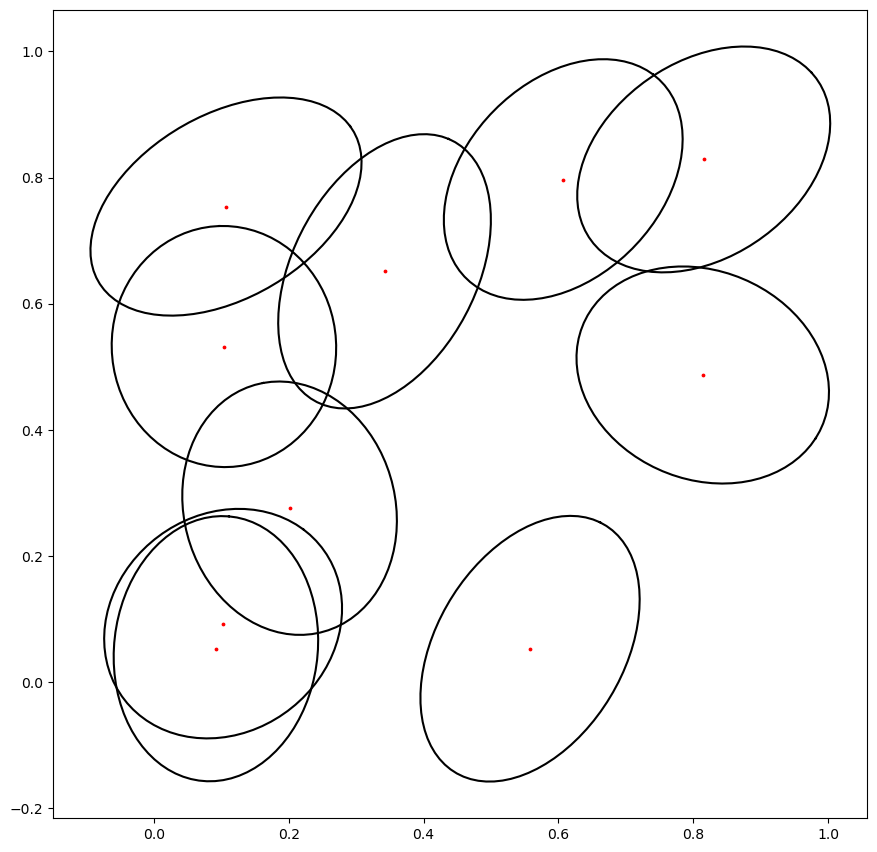

In [27]:
apd1.plot_ellipses()

## Pixel method -- computing an APD, finding optimal APDs, Lloyds algorithm

We are now in a position to run through the capabilities of the library. 

With `apd1.pixel_params` specified, we can proceed to assembling the pixels, which will be stored at `apd1.Y` and their LazyTensor counterparts at `apd1.y`.

In preparation for future updates with regards to adaptable pixel sizes, we also store size of each pixel separate at `apd1.PS`

In [28]:
apd1.assemble_pixels()

In [29]:
apd1.Y

tensor([[0.0081, 0.0081],
        [0.0081, 0.0242],
        [0.0081, 0.0403],
        ...,
        [0.9919, 0.9597],
        [0.9919, 0.9758],
        [0.9919, 0.9919]], device='cuda:0')

In [30]:
apd1.y

In [31]:
apd1.PS

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003], device='cuda:0')

As we can see, we have $M^D$ pixels

In [32]:
import math
print(len(apd1.Y))
math.prod(apd1.pixel_params)

3844


3844

For a fixed triplet of seed points $\{X\}_{i=1}^N$, anisotropy matrices $\{\mathbf A_i\}_{i=1}^N$ and weights $\{w_i\}_{i=1}^N$, we can assemble the APD as follows.

In [33]:
apd1.assemble_apd()

tensor([8, 8, 8,  ..., 6, 6, 6], device='cuda:0')

This is an assignment vector assign each pixel to a grain:

In [34]:
len(apd1.assemble_apd())

3844

With APD computed, we can plot it as follows.

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

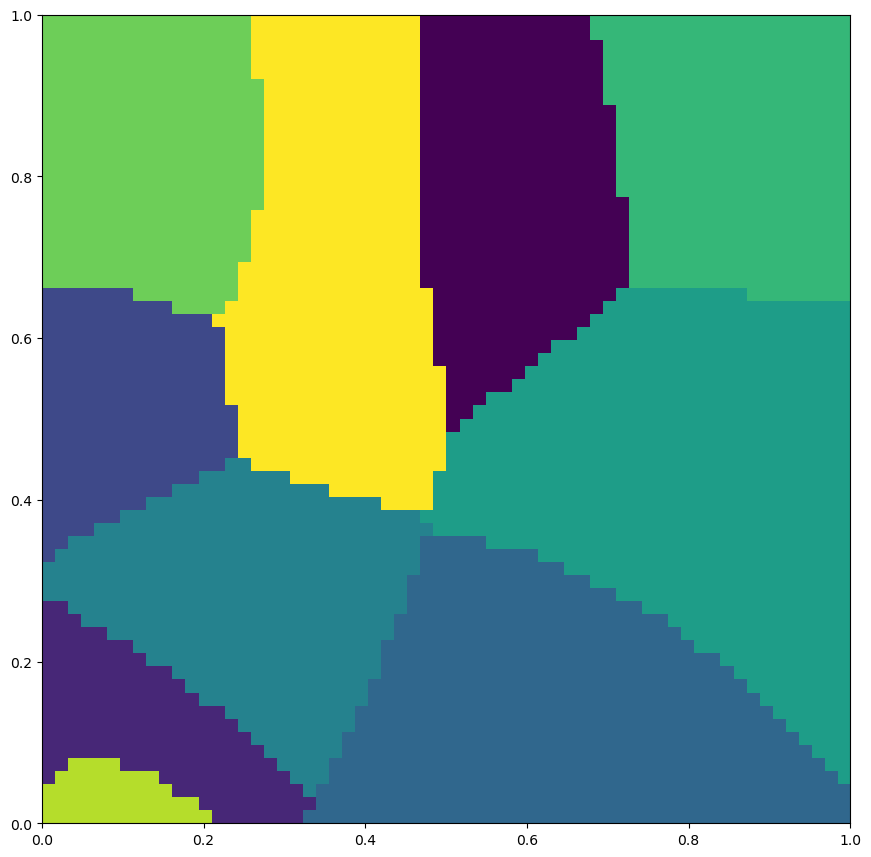

In [35]:
apd1.plot_apd()

We can further check whether the current APD is optimal with respect to target masses:

In [36]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  90.16633605957031


and find the set of optimal weights by calling:

In [37]:
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.055539
         Iterations: 9
         Function evaluations: 11
It took 1.156646966934204 seconds to find optimal W.


In [38]:
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.9364411234855652


Let us plot it.

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

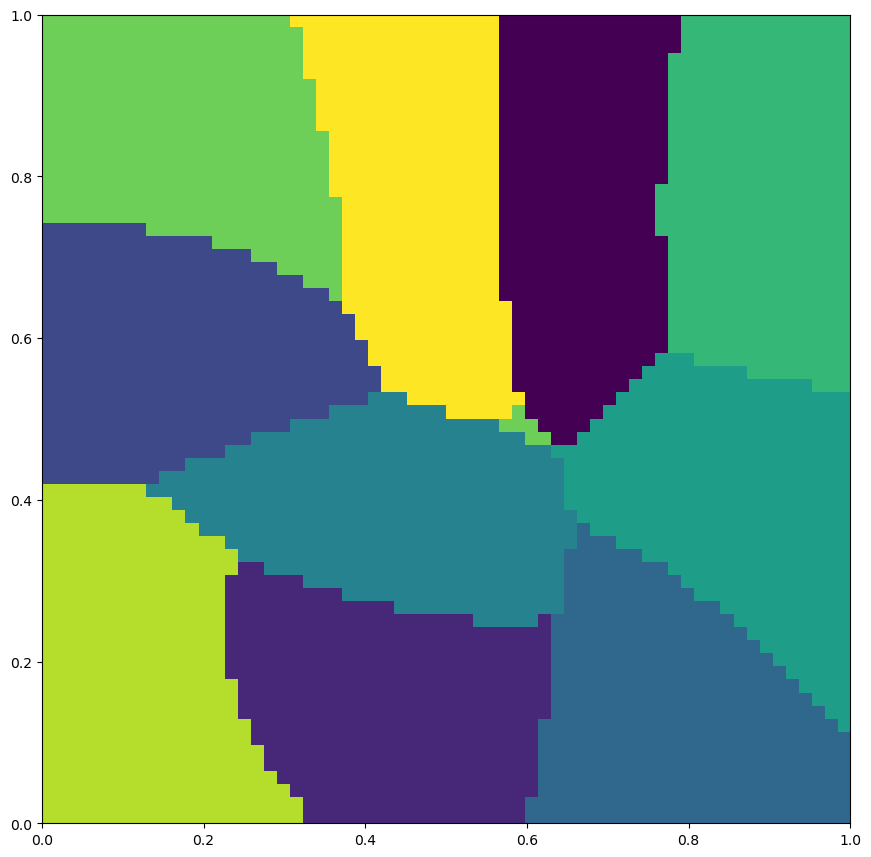

In [39]:
apd1.plot_apd()

Since this is a random run and there are not that many grains, it is likely that some grains will be disjoint. To correct for it, we can run a generalised Lloyds algorithm as follows.

In [40]:
apd1.Lloyds_algorithm(verbosity_level=2)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.055540
         Iterations: 1
         Function evaluations: 3
It took 0.22023749351501465 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.6762668490409851
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.019133
         Iterations: 10
         Function evaluations: 11
It took 1.1903018951416016 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.41615962982177734
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010, device='cuda:0')
Optimality condition suc

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

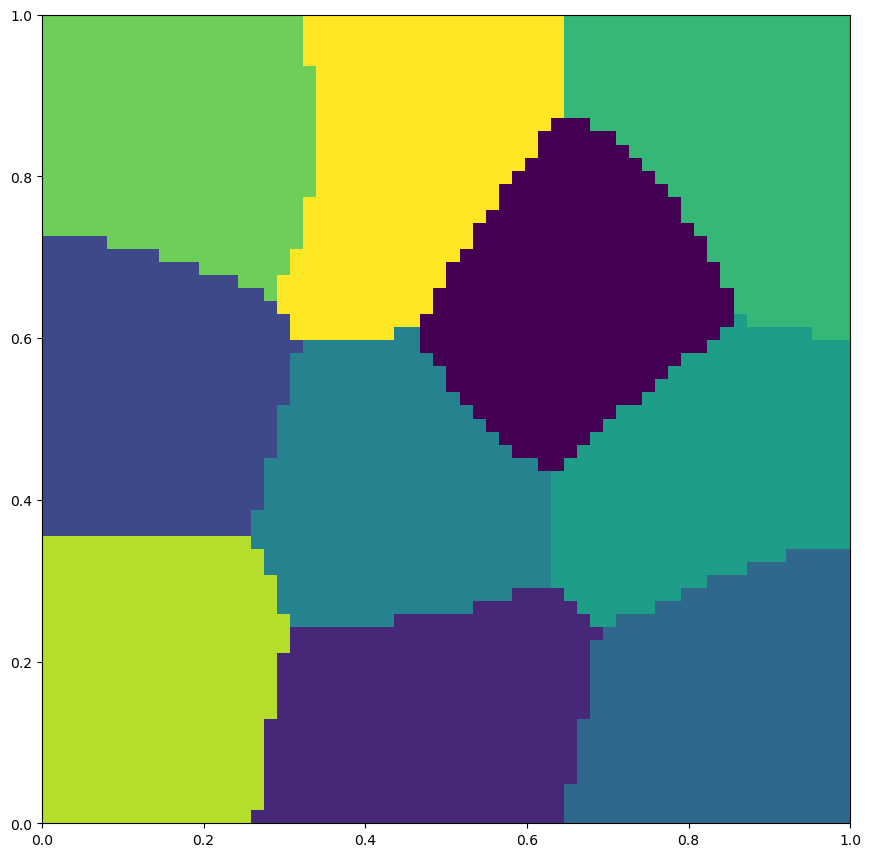

In [41]:
apd1.plot_apd()

If the resulting APD still has disjoint grains, just run a few more iterations of Lloyds. In any case, we see that this is an interesting approximate space filling algorithm, since now the ellipses are nicely spread out.

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

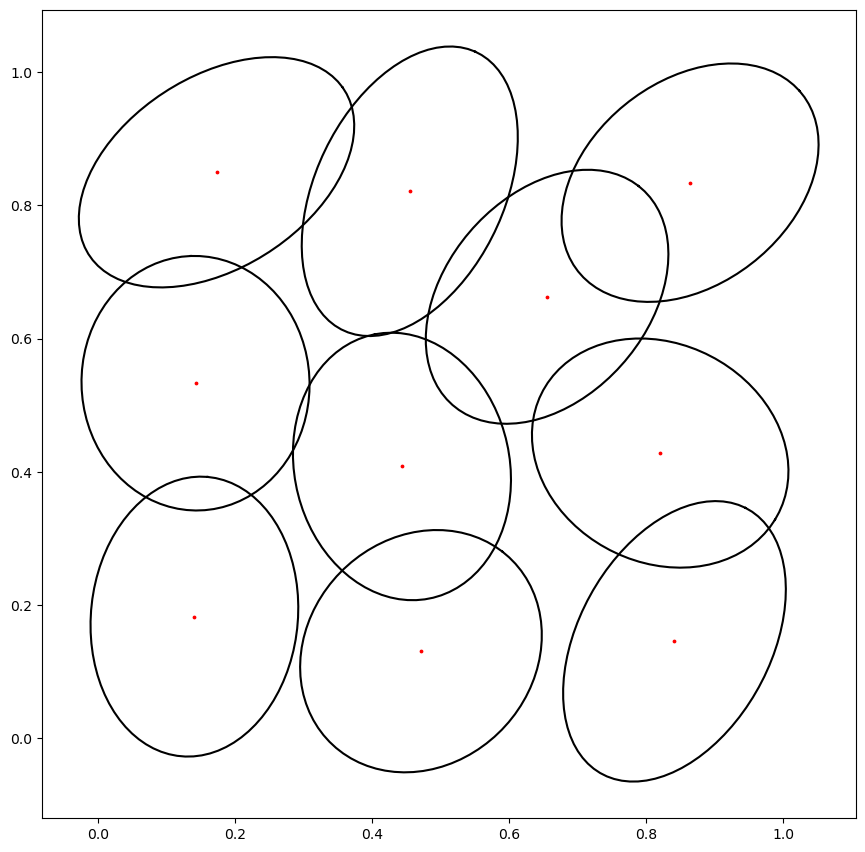

In [42]:
apd1.plot_ellipses()

One further comment is that for plotting we may wish to increase the pixel parameter $M$, which can be done quickly as follows.

In [43]:
apd1.pixel_size_prefactor = 10
apd1.set_pixel_params(verbose=True)
apd1.assemble_pixels()
len(apd1.Y)**(1/2)

M =  310


310.0

(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

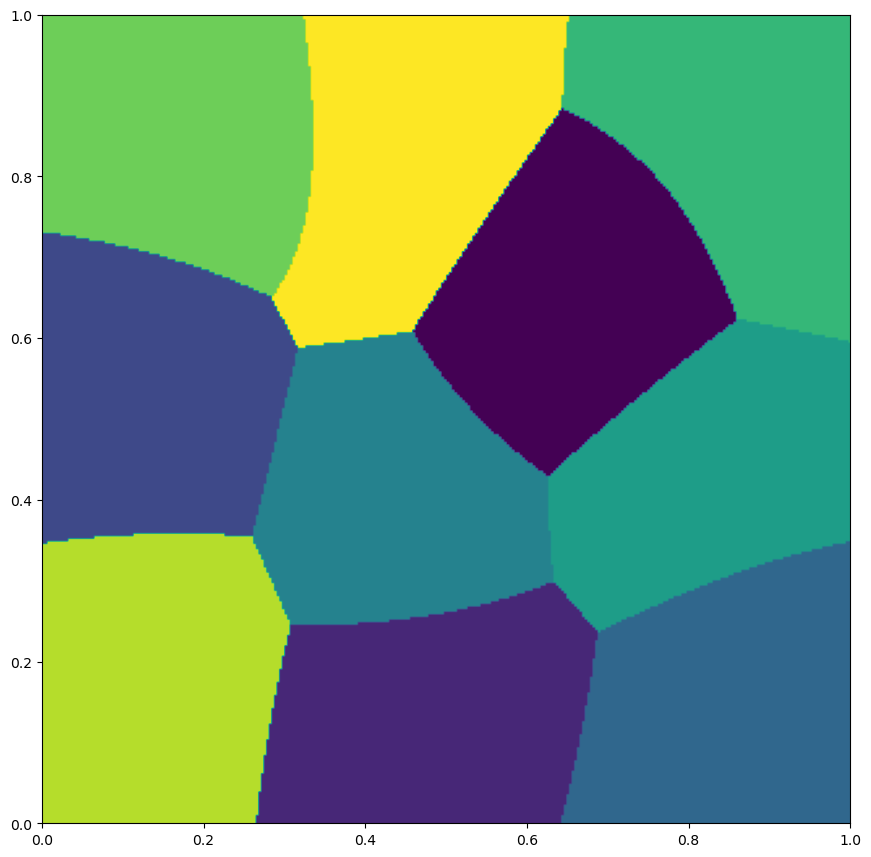

In [44]:
apd1.plot_apd()

What's worth noting is that this only needs to happen at the plotting stage -- for finding optimal set of weights, we are typically alright with much lower values of this parameter. 

## A big example to finish off

The method is rather fast, even on the `T4 GPU` from Google Colab, which we can demonstrate quickly as follows.

In [45]:
apd1 = PyAPD.apd_system(N = 5000, heuristic_W = True)

In [46]:
apd1.pixel_params

(1414, 1414)

In [47]:
apd1.assemble_pixels()

In [48]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  399.4126892089844


In [49]:
import time
start=time.time()
apd1.assemble_apd()
time_taken = time.time()-start
print('It took',time_taken, "seconds to compute an APD.")

It took 0.06335330009460449 seconds to compute an APD.


(<Figure size 1050x1050 with 1 Axes>, <Axes: >)

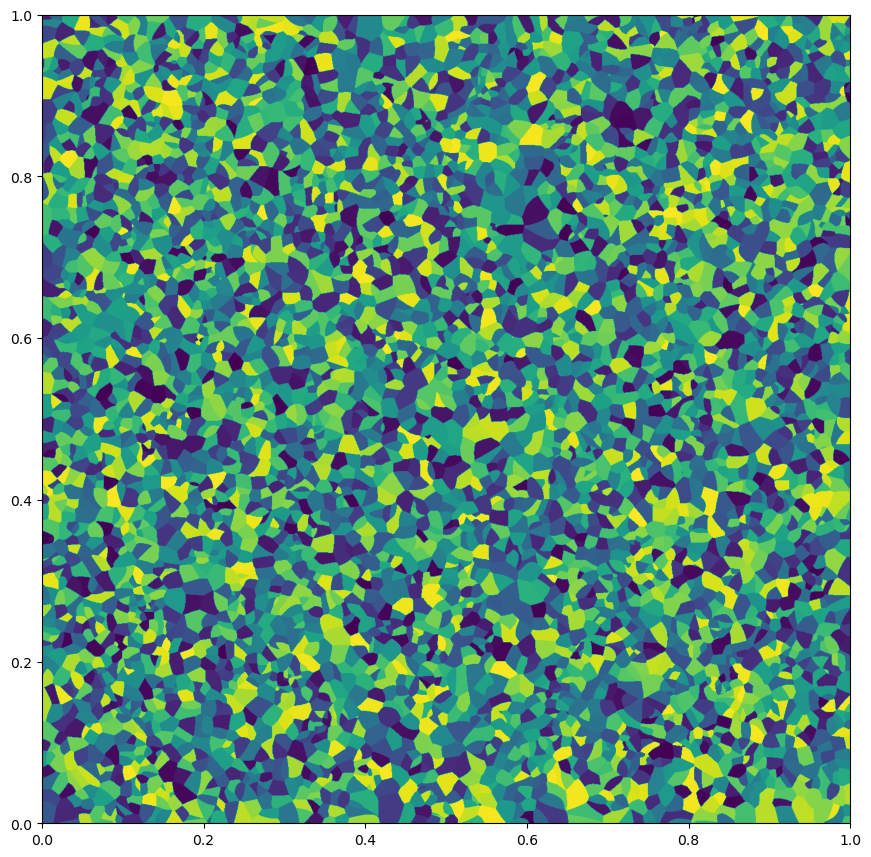

In [50]:
apd1.plot_apd()

In [51]:
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(2.0000e-06, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.000172
         Iterations: 434
         Function evaluations: 719
It took 221.92954277992249 seconds to find optimal W.


It is fast in 3D too.

In [52]:
apd1 = PyAPD.apd_system(N = 5000, D = 3, heuristic_W = True)

In [53]:
apd1.pixel_params

(158, 158, 158)

In [54]:
apd1.assemble_pixels()

In [55]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  207.02581787109375


In [56]:
import time
start=time.time()
apd1.assemble_apd()
time_taken = time.time()-start
print('It took',time_taken, "seconds to compute an APD.")

It took 0.2620527744293213 seconds to compute an APD.


In [57]:
# Plotting in 3D not yet natively implemented, but we recommend 
# PyVista as a plug in to plot a 3D APDs
# using the assignment vector computed above.

# apd1.plot_apd()


In [58]:
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(2.0000e-06, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.001607
         Iterations: 95
         Function evaluations: 105
It took 61.928802490234375 seconds to find optimal W.
